Download a sample image for demonstration purposes.

In [ ]:
!wget -O sample.jpg https://cdn.pixabay.com/photo/2024/02/28/07/42/european-shorthair-8601492_640.jpg

In [1]:
# Import all the required libraries
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json

### Define the image transformations
Before passing the image to the model, we make sure input images are of the same size. 
CNN deals with tensors, so we need to transform the input image into a tensor. 
Normalization is a good practice before passing data to the model.

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

### Load Image

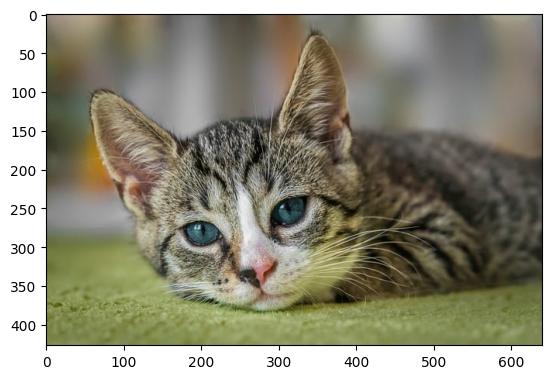

In [3]:
image = Image.open('sample.jpg')
plt.imshow(image)

### Load Model
We are using the Resnet18 model pre-trained on the ImageNet dataset.

In [4]:
model = models.resnet18(pretrained=True)
print(model)

/Users/mdaniyalk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mdaniyalk/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/mdaniyalk/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Extract Conv2d Layers and Weights

In [5]:
# Save the conv layer weights in this list
model_weights = []
# Save the 49 conv layers in this list
conv_layers = []
# Get all the model children as list
model_children = list(model.children())
# Counter to keep count of the conv layers
counter = 0
# Append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f'Total convolution layers: {counter}')
print('conv_layers')

Total convolution layers: 17
conv_layers


### Check for GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### Apply transformation on the image, Add the batch size, and load on GPU

In [7]:
image = transform(image)
print(f'Image shape before: {image.shape}')
image = image.unsqueeze(0)
print(f'Image shape after: {image.shape}')
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


### Generate Feature Maps

In [8]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
# Print feature maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


### Convert 3D tensor to 2D

In [9]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(14, 14)
(14, 14)
(14, 14)
(14, 14)


### Plotting Feature Maps and Save

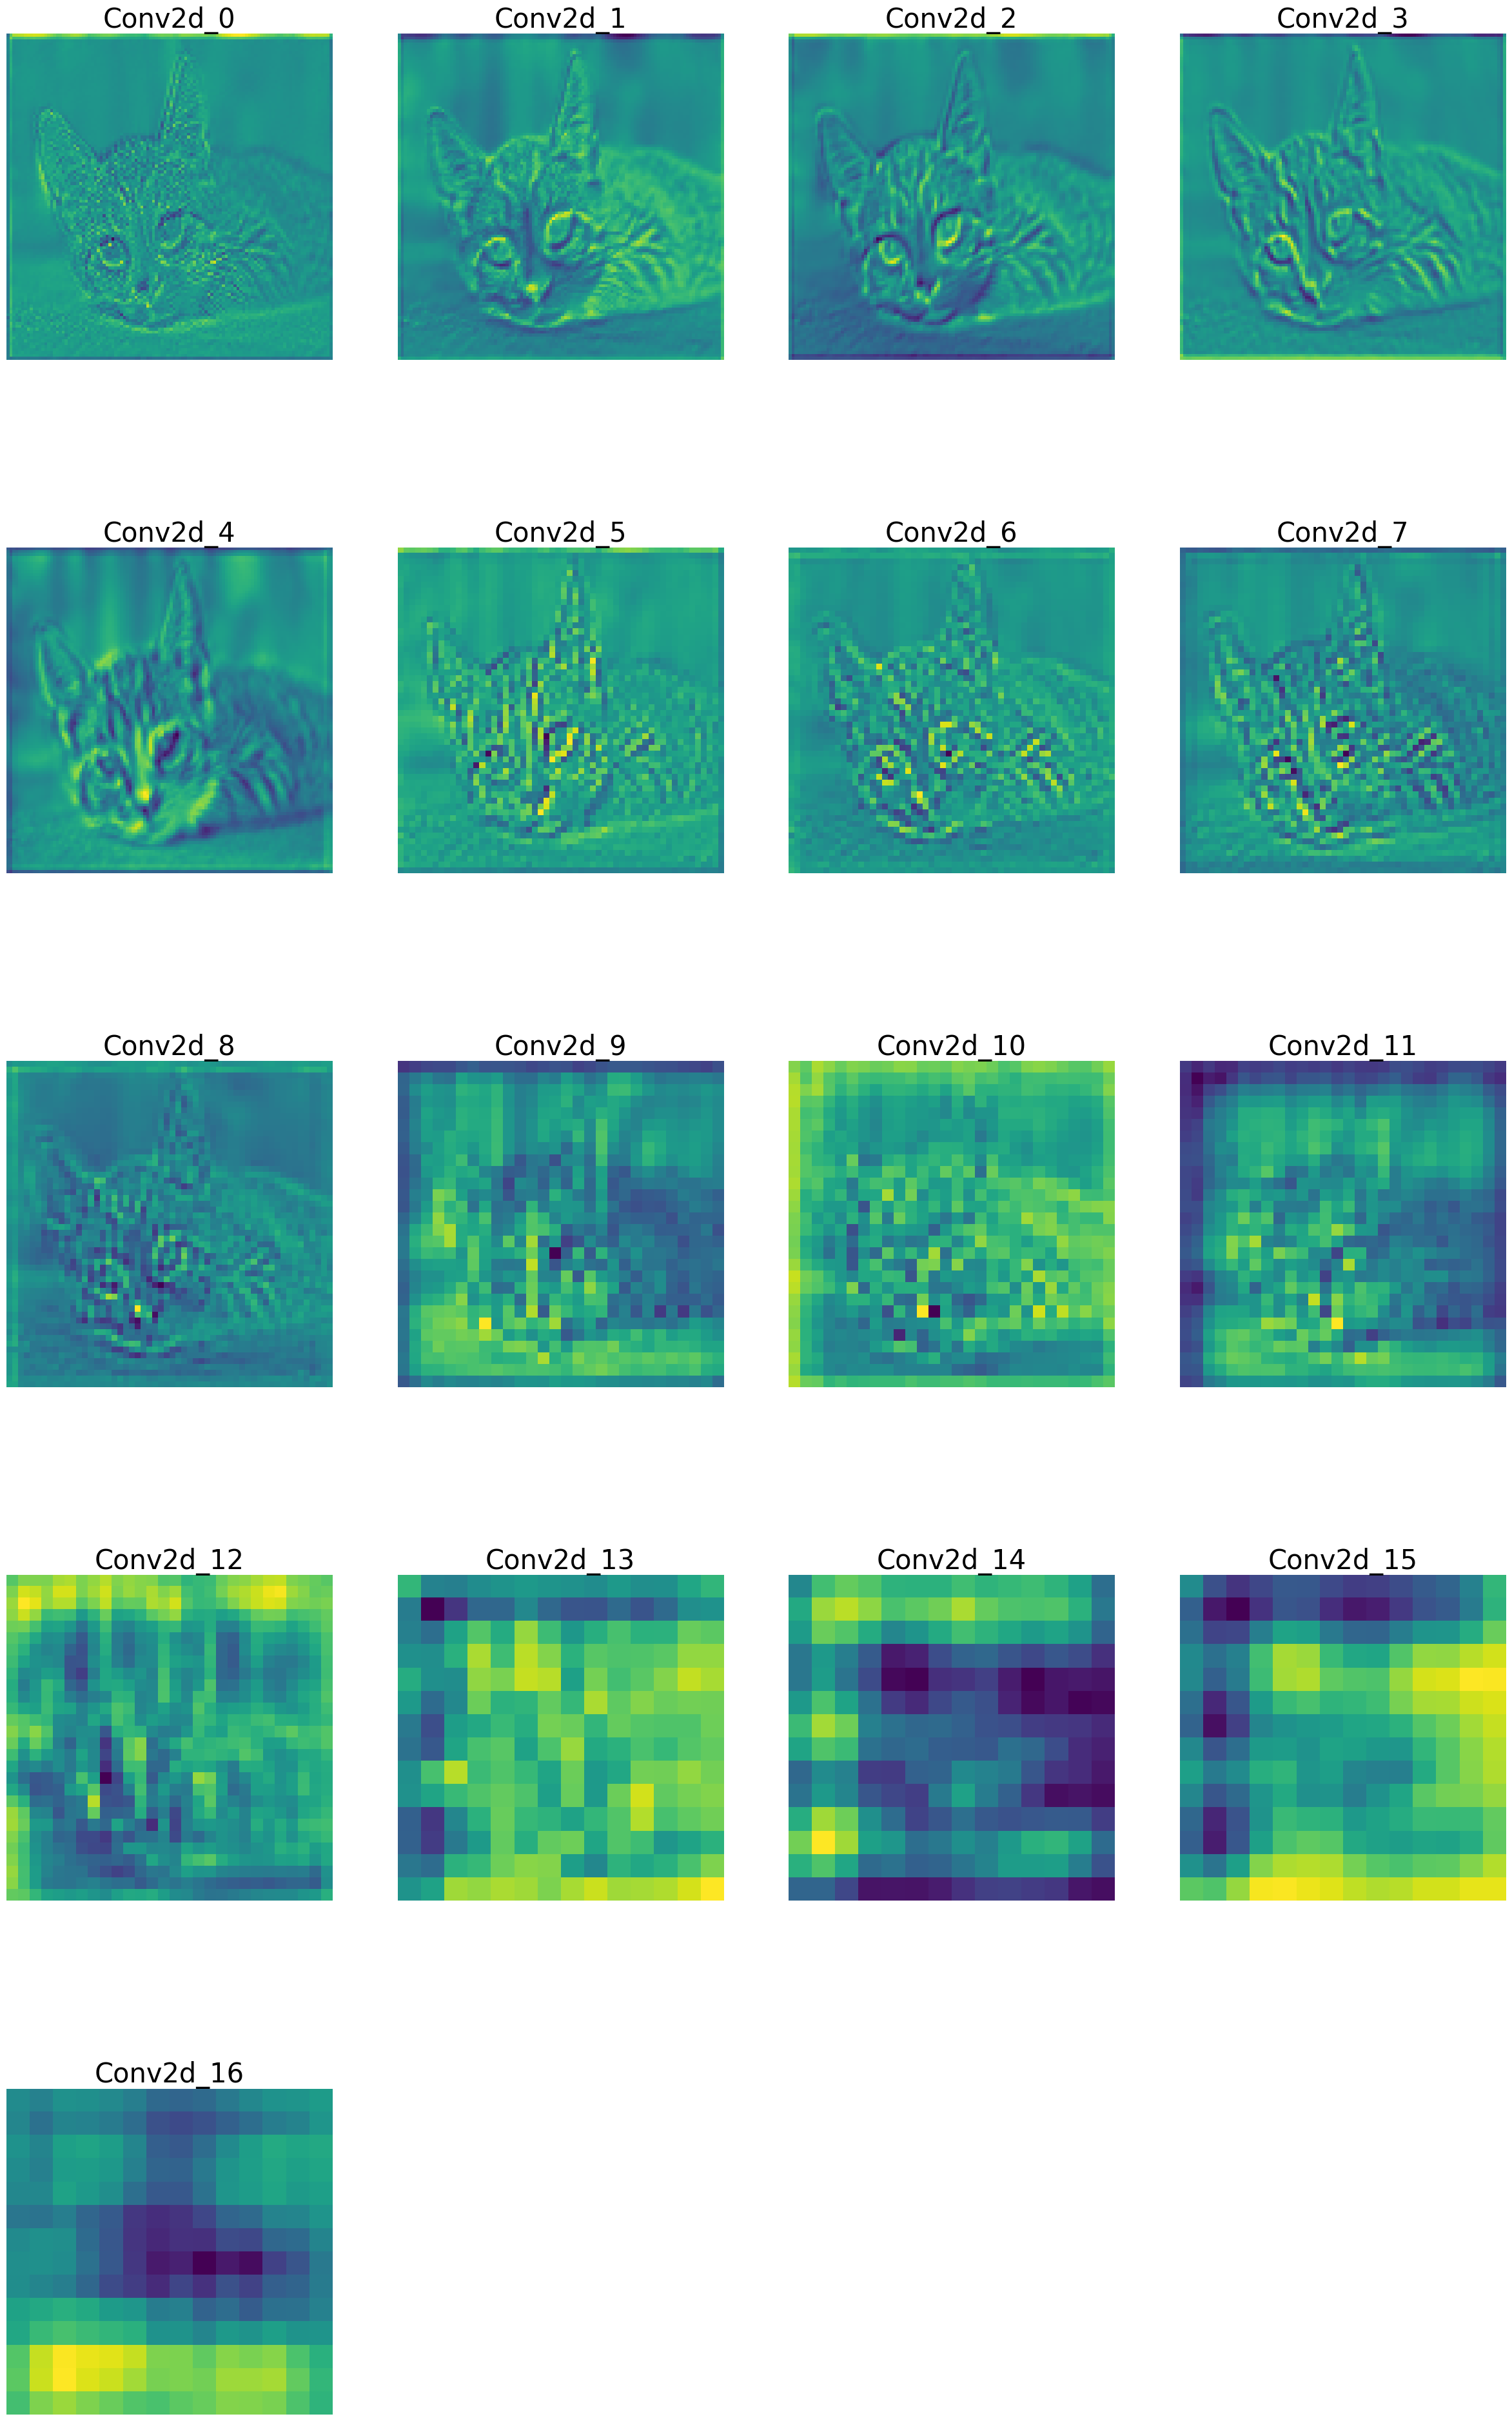

In [11]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i + 1)
    imgplot = plt.imshow(processed[i])
    a.axis('off')
    a.set_title(names[i].split('(')[0]+f"_{i}", fontsize=30)
plt.savefig('feature_maps.jpg', bbox_inches='tight')